<a href="https://colab.research.google.com/github/mikethisyamondol/digit_recognizer/blob/main/digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit Recognizer: MNIST Dataset
<br>
Mike Thisyamondol

### Ingest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
from IPython import display
import pickle
import datetime
import os
from IPython.display import clear_output, Image

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, InputLayer
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.backend import clear_session
from keras.callbacks import History 
import tensorflow as tf

%matplotlib inline

In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Hqs_GVKEqC24F_Ieth0wlV7DM6BTmUS0' -O kaggle.json.zip

clear_output()

In [3]:
with zipfile.ZipFile('kaggle.json.zip', 'r') as zip_ref:
    zip_ref.extractall('kaggle.json')

In [4]:
! pip install kaggle

clear_output()

In [5]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
! cp ./kaggle.json/kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle competitions download digit-recognizer
clear_output()

In [9]:
df_train = pd.read_csv('./train.csv.zip')
df_test = pd.read_csv('./test.csv.zip')

### Quick EDA & Tranformations

In [10]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# Check nulls
df_train.isnull().sum()[df_train.isnull().sum() > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [12]:
# Check nulls
df_test.isnull().sum()[df_test.isnull().sum() > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [13]:
# Check label class distribution
df_train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [14]:
df_train['pixel34'].value_counts()

0      41995
85         1
2          1
157        1
132        1
67         1
Name: pixel34, dtype: int64

In [15]:
x = df_train.drop(['label'], axis = 1)
y = df_train['label']

In [16]:
# Nomalize image data based on 255 pixel values

x /= 255 
holdout = df_test/255

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### Modeling/Experiment

In [18]:
def cross_val(model, x_train, y_train):
  start = datetime.datetime.now()
  kf = StratifiedKFold(n_splits=7, shuffle=True)
  c = cross_val_score(model, x_train, y_train, cv=kf)
  end = datetime.datetime.now()
  print(f'Cross Validation Score: {c.mean().round(3)} ± {c.std().round(3)} // Time: {end-start}')


In [19]:
def model_fit(model, x_train, y_train, x_test, y_test):
  start = datetime.datetime.now()
  model.fit(x_train, y_train)
  end = datetime.datetime.now()
  print(f'Oob Score: {model.oob_score_}')
  print(f'Test Score: {model.score(x_test, y_test)}')
  print(f'Training Time: {end-start}')
  return model

#### Random Forest

In [20]:
rf1 = RandomForestClassifier(oob_score=True, n_estimators=200)
cross_val(rf1, x_train, y_train)

Cross Validation Score: 0.964 ± 0.002 // Time: 0:05:54.650021


In [21]:
rf1 = model_fit(rf1, x_train, y_train, x_test, y_test)

Oob Score: 0.9630357142857143
Test Score: 0.9672619047619048
Training Time: 0:00:56.709601


In [22]:
# Training Preds
rf1_preds_train = rf1.predict(x_test)
rf1_preds_train_df = pd.DataFrame(rf1_preds_train, columns=['preds'])
rf1_preds_train_df["target"] = list(y_test)

In [23]:
target_name = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(rf1_preds_train_df['target'], rf1_preds_train_df['preds'], target_names=target_name))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       813
           1       0.98      0.99      0.98       950
           2       0.96      0.98      0.97       817
           3       0.95      0.94      0.95       858
           4       0.96      0.97      0.97       830
           5       0.97      0.96      0.96       734
           6       0.98      0.98      0.98       897
           7       0.97      0.97      0.97       899
           8       0.97      0.95      0.96       760
           9       0.95      0.95      0.95       842

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [24]:
# # Kaggle Prediction
# rf1_preds = rf1.predict(holdout)
# rf1_preds = pd.Series(rf1_preds, name="Label")

# submission1 = pd.concat([pd.Series(range(len(holdout)), name = "ImageId"), rf1_preds], axis = 1)
# submission1['ImageId'] = submission1['ImageId']+1
# submission1.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/digit_submission1.csv', index=False)

#### Random Forest with PCA

In [25]:
pca = PCA()
pca = pca.fit(x_train)

In [26]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
n = np.argmax(cum_var_exp >= 0.95) + 1

Text(0.5, 1.0, 'Component vs Cumulative variance explained\n')

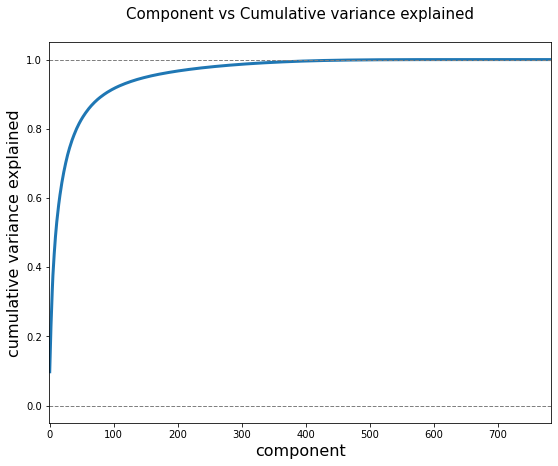

In [27]:
plt.figure(figsize=(9,7))

component_number = range(len(cum_var_exp))
plt.plot(component_number, cum_var_exp, lw=3)

plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([-1,len(cum_var_exp)])
ax.set_ylim([-0.05,1.05])
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)
ax.set_title('Component vs Cumulative variance explained\n', fontsize=15)

In [28]:
pca = PCA(n_components = n)
z_train = pca.fit_transform(x_train)
z_test = pca.transform(x_test)

In [29]:
z_train.shape

(33600, 153)

In [30]:
rf2 = RandomForestClassifier(oob_score=True, n_estimators=200)
cross_val(rf2, z_train, y_train)

Cross Validation Score: 0.942 ± 0.002 // Time: 0:12:01.089699


In [31]:
rf2 = model_fit(rf2, z_train, y_train, z_test, y_test)

Oob Score: 0.9370833333333334
Test Score: 0.9451190476190476
Training Time: 0:01:57.872429


It's not surprising that the model using PCA did not perform as well, given there might be some pixel data that doesn't make it into the model that might make let's say a 4 and a 9 indistinguishable. The surprising thing is that the model using PCA took a longer time to fit than the first model without PCA. 

In [32]:
# Training Preds
rf2_preds_train = rf2.predict(z_test)
rf2_preds_train_df = pd.DataFrame(rf2_preds_train, columns=['preds'])
rf2_preds_train_df["target"] = list(y_test)

In [33]:
print(classification_report(rf2_preds_train_df['target'], rf2_preds_train_df['preds'], target_names=target_name))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       813
           1       0.97      0.98      0.98       950
           2       0.93      0.95      0.94       817
           3       0.91      0.91      0.91       858
           4       0.95      0.94      0.95       830
           5       0.94      0.92      0.93       734
           6       0.96      0.97      0.97       897
           7       0.95      0.96      0.95       899
           8       0.93      0.91      0.92       760
           9       0.94      0.91      0.93       842

    accuracy                           0.95      8400
   macro avg       0.94      0.94      0.94      8400
weighted avg       0.95      0.95      0.95      8400



In [34]:
# # Kaggle Prediction
# test_reduced = pca.transform(holdout)
# rf2_preds = rf2.predict(test_reduced)
# rf2_preds = pd.Series(rf2_preds, name="Label")

# submission2 = pd.concat([pd.Series(range(len(holdout)), name = "ImageId"), rf2_preds], axis = 1)
# submission2['ImageId'] = submission2['ImageId']+1
# submission2.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/digit_submission2.csv', index=False)

#### K-Means Clustering

In [35]:
# map cluster to labels
def get_reference_dict(clusters, data_label):
    reference_label = {}
    for i in range(len(np.unique(clusters))):
        index = np.where(clusters == i,1,0)
        num = np.bincount(data_label[index==1]).argmax()
        reference_label[i] = num
    return reference_label

# map predictions to labels
def get_labels(clusters, reference_labels):

    number_labels = np.random.rand(len(clusters))
    for i in range(len(clusters)):
        number_labels[i] = reference_labels[clusters[i]]
    return number_labels

In [36]:
# Using 10 Clusters
n = len(y.unique())
km = KMeans(n_clusters=n)
km.fit(x)
clusters = km.predict(x)

In [37]:
reference_labels = get_reference_dict(clusters, y)
predicted_labels = get_labels(clusters, reference_labels)
print(reference_labels)
print(accuracy_score(predicted_labels, y))

{0: 2, 1: 7, 2: 3, 3: 1, 4: 4, 5: 5, 6: 1, 7: 6, 8: 8, 9: 0}
0.5852380952380952


In [38]:
print(f'Inertia: {km.inertia_}')

Inertia: 1648379.9938884084


In [39]:
cm = confusion_matrix(y, predicted_labels)
cm_df = pd.DataFrame(cm, columns = ["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5", "Predicted 6", "Predicted 7", "Predicted 8", "Predicted 9"], 
                     index = ["Actual 0", "Actual 1", "Actual 2", "Actual3", "Actual 4", "Actual 5", "Actual 6", "Actual 7", "Actual 8", "Actual 9"])
cm_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,2915,3,4,181,26,858,108,3,34,0
Actual 1,0,4655,3,5,3,3,4,5,6,0
Actual 2,27,518,2887,191,131,130,107,47,139,0
Actual3,16,318,107,2755,122,352,27,25,629,0
Actual 4,5,266,23,0,2283,98,107,1281,9,0
Actual 5,37,316,6,1313,244,1113,47,147,572,0
Actual 6,60,237,31,23,46,855,2871,2,12,0
Actual 7,12,406,31,5,1310,6,4,2612,15,0
Actual 8,24,387,26,677,114,193,36,117,2489,0
Actual 9,31,223,7,49,2121,18,11,1673,55,0


In [40]:
# km_test_preds = km.predict(holdout)
# test_predicted_labels = get_labels(km_test_preds, reference_labels)
# test_predicted_labels = np.array([int(x) for x in test_predicted_labels])

# km_preds = pd.Series(test_predicted_labels, name="Label")
# submission3 = pd.concat([pd.Series(range(len(holdout)), name = "ImageId"), km_preds], axis = 1)
# submission3['ImageId'] = submission3['ImageId']+1
# submission3.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/digit_submission3.csv', index=False)

The k-means clustering model did not perform very well with an accuracy of ~60%. I'm curious if increasing the number of clusters would increase the accuracy score, the reason being a given number can be written in different ways, some of which have similarities to other numbers. It would be interesting to see how much the model improves with a higher number of clusters.

Increasing number of Clusters:

In [41]:
# Using 30 Clusters
km2 = MiniBatchKMeans(n_clusters=n*3)
km2.fit(x)
clusters2 = km2.predict(x)

In [42]:
reference_labels2 = get_reference_dict(clusters2, y)
predicted_labels2 = get_labels(clusters2, reference_labels2)
print(reference_labels2)
print(accuracy_score(predicted_labels2, y))

{0: 4, 1: 1, 2: 3, 3: 0, 4: 7, 5: 6, 6: 4, 7: 9, 8: 3, 9: 0, 10: 4, 11: 0, 12: 1, 13: 1, 14: 8, 15: 1, 16: 9, 17: 7, 18: 0, 19: 2, 20: 5, 21: 3, 22: 4, 23: 6, 24: 8, 25: 2, 26: 7, 27: 6, 28: 5, 29: 2}
0.7304761904761905


In [43]:
print(f'Inertia: {km2.inertia_}')

Inertia: 1405622.068054216


In [44]:
cm2 = confusion_matrix(y, predicted_labels2)
cm_df2 = pd.DataFrame(cm2, columns = ["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5", "Predicted 6", "Predicted 7", "Predicted 8", "Predicted 9"], 
                     index = ["Actual 0", "Actual 1", "Actual 2", "Actual3", "Actual 4", "Actual 5", "Actual 6", "Actual 7", "Actual 8", "Actual 9"])
cm_df2

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,3796,14,5,77,9,132,85,0,9,5
Actual 1,0,4632,10,7,2,4,3,2,5,19
Actual 2,63,402,3332,102,51,36,29,38,89,35
Actual3,67,174,86,3164,20,191,16,35,517,81
Actual 4,3,163,13,10,2990,16,53,199,1,624
Actual 5,63,212,3,1073,103,1965,47,32,247,50
Actual 6,112,250,0,34,12,143,3572,3,10,1
Actual 7,4,193,25,3,284,4,2,3186,8,692
Actual 8,40,223,31,727,118,189,19,27,2571,118
Actual 9,20,88,3,62,1975,19,6,523,20,1472


In [45]:
# km_test_preds2 = km2.predict(holdout)
# test_predicted_labels2 = get_labels(km_test_preds2, reference_labels2)
# test_predicted_labels2 = np.array([int(x) for x in test_predicted_labels2])

# km_preds2 = pd.Series(test_predicted_labels2, name="Label")
# submission4 = pd.concat([pd.Series(range(len(holdout)), name = "ImageId"), km_preds2], axis = 1)
# submission4['ImageId'] = submission4['ImageId']+1
# submission4.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/digit_submission4.csv', index=False)

Increasing the number of clusters from 10 to 30 seems to improve the number predictions. It would be interesting to see if the performance can match that of the Random Forest models above by increasing the number of clusters.

#### Neural Network - Keras

In [46]:
## Quick Preprocessing
x = df_train.drop(['label'], axis = 1)
y = df_train['label']

# Reshape (height = 28px, width = 28px , canal = 1) + Normalize Data
x = x.values.reshape(-1, 28, 28, 1)/255
holdout = df_test.values.reshape(-1, 28, 28, 1)/255

# Encode labels to one hot vectors
y = to_categorical(y, num_classes = 10)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify=y)

In [47]:
x.shape


(42000, 28, 28, 1)

In [48]:
holdout.shape

(28000, 28, 28, 1)

In [49]:
def build_nn(num_layers, num_nodes):
  # build out hidden layers based on num_layers and num_nodes arguments.
  dense_layers = [Dense(num_nodes, activation='relu') for _ in range(num_layers)]
  # combine all layers including input layer, hidden layers, dropout layer, and output layer
  layers = [Flatten(input_shape=[28, 28, 1])] + dense_layers + [Dropout(0.2)] +  [Dense(10, activation='softmax')]
  # pass in topology array
  model = Sequential(layers)

  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 8,070
Trainable params: 8,070
Non-trainable params: 0
_________________________________________________________________



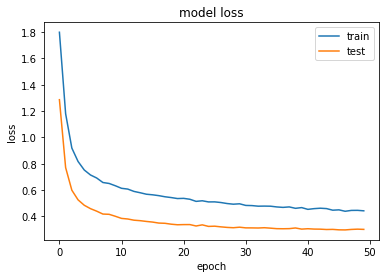

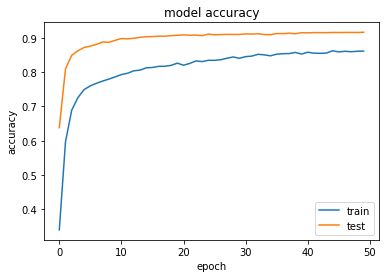

------------------------------------------------------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 20)                15700     
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 16,330
Trainable params: 16,330
Non-trainable params: 0
___

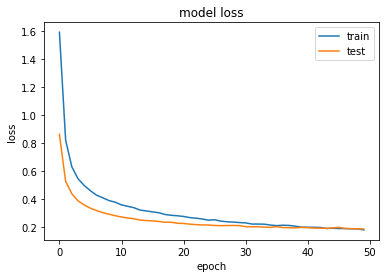

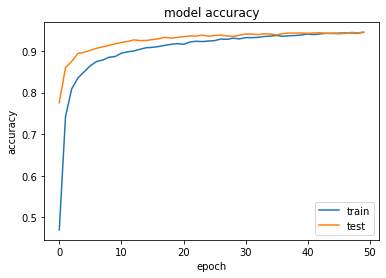

------------------------------------------------------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
       

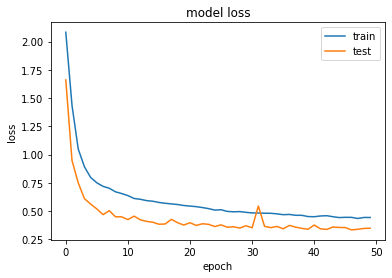

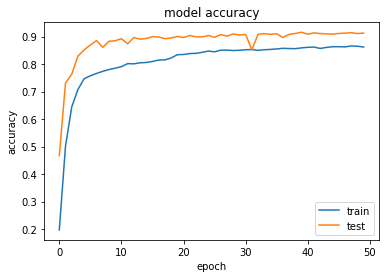

------------------------------------------------------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 20)                15700     
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
       

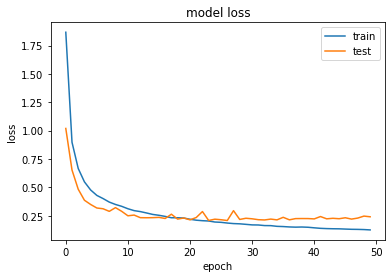

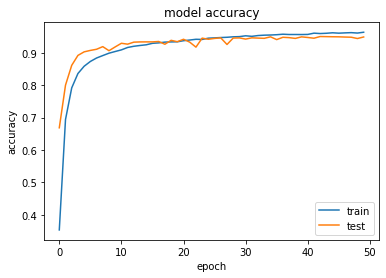

------------------------------------------------------------------------------------------------------------------
CPU times: user 6min 34s, sys: 23.3 s, total: 6min 57s
Wall time: 7min 33s


In [50]:
%%time
num_layers = [2, 5]
num_nodes = [10, 20]
results = []
count = 1

for l in num_layers:
  for n in num_nodes:
    clear_session()

    model = build_nn(l, n)
    model.compile(loss="categorical_crossentropy",
                  optimizer="sgd",
                  metrics=["acc"])
    
    start = datetime.datetime.now()

    history = History()
    model.fit(x_train, 
              y_train, 
              epochs=50, 
              validation_split=0.25,
              callbacks=[history],
              verbose=0)
    
    end = datetime.datetime.now()

    model.summary()
    print('')

    # Plot loss over time.
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show();

    # Plot accuracy over time.
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

    # train_score = model.evaluate(x_train, y_train, verbose=0)
    # test_score = model.evaluate(x_test, y_test, verbose=0)

    results.append({'layers': l, 'nodes': n, 'fit_time': (end-start).total_seconds(), 
                    'train_accuracy': history.history['acc'][-1], 'test_accuracy': history.history['val_acc'][-1]})
    
    plot_model(model, to_file=f'model_{count}.png', show_shapes=True, show_layer_names=True)

    count+=1
    print('------------------------------------------------------------------------------------------------------------------')

In [51]:
df_results = pd.DataFrame(results)
df_results

,layers,nodes,fit_time,train_accuracy,test_accuracy
0,2,10,81.722241,0.861865,0.916905
1,2,20,83.087623,0.945357,0.945119
2,5,10,142.513942,0.861865,0.912381
3,5,20,142.550653,0.962937,0.948333


It's quite clear that the 20 node models perform better than the models using 10 nodes, although not much of a difference between 2 layers and 5 layers. I suspect this is due to the Dropout layer (with 0.2 dropout rate) that was added to prevent overfitting. It does seem like the 2 layer/20 node model is better at generalizing data and takes roughly half the time to fit. 

Both adam and sgd optimizers were tested. Although it seemed as though adam converged quicker, sgd seemed to generalize better. After doing a bit research, it looks like 'AdaBound' brings the best of both worlds, and will be experimented with in a future iteration.

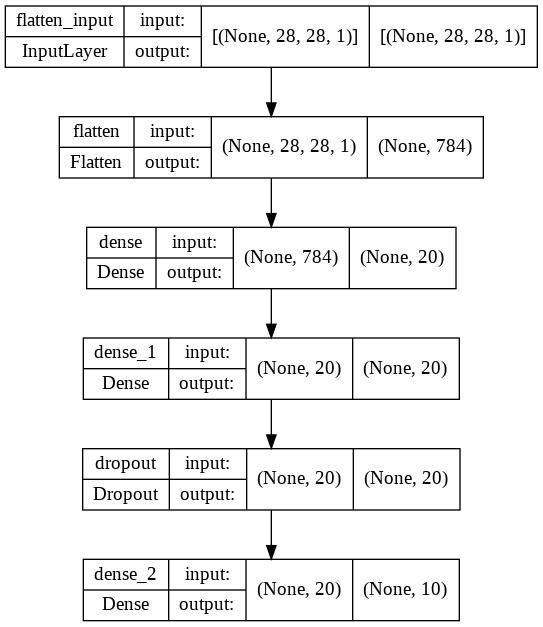

In [52]:
# Check Topology
Image('model_2.png')

In [53]:
%%time
model = build_nn(2, 20)
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["acc"])

history = History()
model.fit(x_train, 
          y_train, 
          epochs=250, # increasing epochs 
          validation_split=0.25,
          callbacks=[history],
          verbose=0)

CPU times: user 8min 3s, sys: 29.8 s, total: 8min 33s
Wall time: 7min 5s


In [54]:
# evaluate model against test split
score = model.evaluate(x_test, y_test, verbose=0)
labels = model.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

loss: 0.2234272062778473
acc: 0.9474999904632568


In [55]:
y_test_preds = model.predict(x_test)
y_test_preds_class = np.argmax(y_test_preds, axis=1)
y_test_ = np.argmax(y_test, axis=1)

In [56]:
# Based on final iteration (5 layers; 20 nodes)
cm = confusion_matrix(y_test_, y_test_preds_class)
cm_df = pd.DataFrame(cm, columns = ["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5", "Predicted 6", "Predicted 7", "Predicted 8", "Predicted 9"], 
                     index = ["Actual 0", "Actual 1", "Actual 2", "Actual3", "Actual 4", "Actual 5", "Actual 6", "Actual 7", "Actual 8", "Actual 9"])
cm_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,809,0,4,0,0,4,3,1,6,0
Actual 1,0,922,5,2,1,0,1,1,3,2
Actual 2,2,4,780,11,6,2,9,7,14,0
Actual3,1,1,14,824,1,15,0,2,8,4
Actual 4,0,2,3,0,760,2,9,2,1,35
Actual 5,1,0,0,28,1,707,12,2,5,3
Actual 6,8,0,1,0,7,13,790,0,8,0
Actual 7,0,4,7,4,5,0,0,843,1,16
Actual 8,11,9,4,10,3,4,5,3,747,17
Actual 9,1,4,0,13,20,8,0,7,8,777


In [61]:
# Kaggle Predictions
# nn_preds = model.predict(holdout)
# nn_preds_class = np.argmax(nn_preds, axis=1)

# nn_preds = pd.Series(nn_preds_class, name='Label')
# submission5 = pd.concat([pd.Series(range(len(holdout)), name='ImageId'), nn_preds], axis=1)
# submission5['ImageId'] += 1
# submission5.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/digit_submission5.csv', index=False)